In [98]:
import pandas as pd
import requests
import os
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

df = pd.read_csv('./data/cs552j_A1_dataset_image_id_url.csv')
df = df.rename(columns={df.columns[0]: 'original_index'})

In [67]:
# Folder where you want to save the image
save_folder = "a1_images"
os.makedirs(save_folder, exist_ok=True)

### Explore dataset

In [99]:
df.head()

,original_index,license,file_name,coco_url,height,width,date_captured,flickr_url,id,label
0,2,4,000000252219.jpg,http://images.cocodataset.org/val2017/00000025...,428,640,2013-11-14 22:32:02,http://farm4.staticflickr.com/3446/3232237447_...,252219,walking_running
1,11,1,000000386912.jpg,http://images.cocodataset.org/val2017/00000038...,480,640,2013-11-15 16:38:19,http://farm5.staticflickr.com/4088/4980393979_...,386912,sitting
2,27,3,000000308394.jpg,http://images.cocodataset.org/val2017/00000030...,428,640,2013-11-17 03:48:10,http://farm4.staticflickr.com/3152/2818802025_...,308394,sitting
3,28,4,000000456496.jpg,http://images.cocodataset.org/val2017/00000045...,426,640,2013-11-17 03:50:41,http://farm4.staticflickr.com/3810/10095484263...,456496,sitting
4,53,1,000000185250.jpg,http://images.cocodataset.org/val2017/00000018...,640,399,2013-11-18 10:07:10,http://farm8.staticflickr.com/7040/6810762896_...,185250,standing


In [5]:
def download_image(image_url, save_folder):
    image_name = os.path.join(save_folder, image_url.split("/")[-1])
    response = requests.get(image_url)
    if response.status_code == 200:
        with open(image_name, "wb") as file:
            file.write(response.content)
        print(f"Image saved at: {image_name}")
    else:
        print("Failed to download image")

- **Downloads all the images to your computer. Do this only once locally, then you can continue.**


In [ ]:
for i in df.coco_url.values:
    download_image(i, save_folder)

# Your Assessment code below

- please make good use of markdown to separate the sections. 

### 1. Data Preparation

In [69]:
image_paths = [os.path.join(save_folder, img) for img in os.listdir(save_folder)]
labels = df['label'].unique().tolist() 
label_mapping = {
    'walking_running': 0,
    'sitting': 1,
    'standing': 2
}

df['numeric_label'] = df['label'].map(label_mapping)

# Count samples per class
class_distribution = df['label'].value_counts()

print("\nClass Distribution:")
print(f"Walking/Running: {class_distribution['walking_running']} samples")
print(f"Sitting: {class_distribution['sitting']} samples")
print(f"Standing: {class_distribution['standing']} samples")

print("\nPercentage Distribution:")
percentage_distribution = df['label'].value_counts(normalize=True) * 100
for label, percentage in percentage_distribution.items():
    print(f"{label}: {percentage:.2f}%")


Class Distribution:
Walking/Running: 98 samples
Sitting: 95 samples
Standing: 92 samples

Percentage Distribution:
walking_running: 34.39%
sitting: 33.33%
standing: 32.28%


### 2. Image Preprocessing and Sample for training and testing

- Training data 80%
- Testing data 20%

In [70]:
def preprocess_image(image):
    try:
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [256, 256])
        image = tf.cast(image, tf.float32) / 255.0  # normalize to [0,1] range
        return image
    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None

def load_and_preprocess_image(path):
    try:
        image = tf.io.read_file(path)
        return preprocess_image(image)
    except Exception as e:
        print(f"Error loading image from {path}: {e}")
        return None

# Create image paths and verify they exist
image_paths = [os.path.join(save_folder, img) for img in os.listdir(save_folder) 
               if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Convert labels to numeric format
numeric_labels = df['numeric_label'].values

# First, verify data exists
print(f"Total images: {len(image_paths)}")
print(f"Total labels: {len(numeric_labels)}")

# Ensure dataset sizes match
assert len(image_paths) == len(numeric_labels), "Number of images and labels must match"

# Create dataset with verification
dataset = tf.data.Dataset.from_tensor_slices((image_paths, numeric_labels))

# Map the loading function
def load_and_preprocess_with_label(path, label):
    image = load_and_preprocess_image(path)
    return image, label

dataset = dataset.map(load_and_preprocess_with_label)

# Split into train and test
train_size = int(0.8 * len(image_paths))
test_size = len(image_paths) - train_size

train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)

# Configure for performance
BATCH_SIZE = 32
BUFFER_SIZE = 1000

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Total images: 285
Total labels: 285


### 3. Model Creation
- CNN Model
- FNN Model

- **CNN Model**

In [71]:
def create_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(3, activation='softmax')  # 3 labels
    ])
    return model

- **CNN with Data Augmentation Model**

In [72]:
def create_cnn_gen_model():
    model = models.Sequential([
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.2),
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),  # Dropout layer for regularization
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])
    return model

- **FNN Model**

In [73]:
def create_fnn_model():
    model = models.Sequential([
        layers.Flatten(input_shape=(256, 256, 3)),
        layers.Dense(512, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])
    return model

### 4. Model Training and Evaluation
 - 30 epochs for each model

In [ ]:
for images, labels in train_ds.take(1):
    print(f"\nBatch shapes:")
    print(f"Images: {images.shape}")
    print(f"Labels: {labels.shape}")

# Initialize and compile models
models_dict = {
    'CNN': create_cnn_model(),
    'FNN': create_fnn_model(),
    'CNN_GEN': create_cnn_gen_model()
}

# Compile models
for model_name, model in models_dict.items():
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

# Train models
epochs = 30
histories = {}

for model_name, model in models_dict.items():
    try:
        print(f"\nTraining {model_name}...")
        history = model.fit(
            train_ds,
            epochs=epochs,
            validation_data=test_ds,
            verbose=1
        )
        histories[model_name] = history
    except Exception as e:
        print(f"Error training {model_name}: {str(e)}")

#### **Model summaries**

- **CNN**

In [92]:
models_dict["CNN"].summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_49 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_50 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_50 (MaxPooli  (None, 30, 30, 128)     

- **FNN**

In [93]:
models_dict["FNN"].summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_25 (Flatten)        (None, 196608)            0         
                                                                 
 dense_50 (Dense)            (None, 512)               100663808 
                                                                 
 dense_51 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 100665347 (384.01 MB)
Trainable params: 100665347 (384.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- **CNN With Data Augmentation**

In [94]:
models_dict["CNN_GEN"].summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_8 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_8 (RandomR  (None, 256, 256, 3)       0         
 otation)                                                        
                                                                 
 conv2d_51 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_51 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_52 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_52 (MaxPooli  (None, 62, 62, 64)      

### 5. Plotting Results

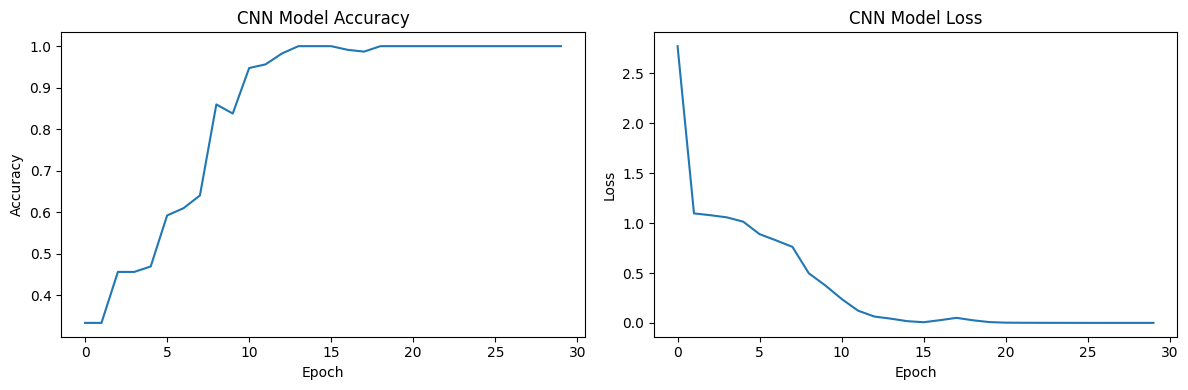

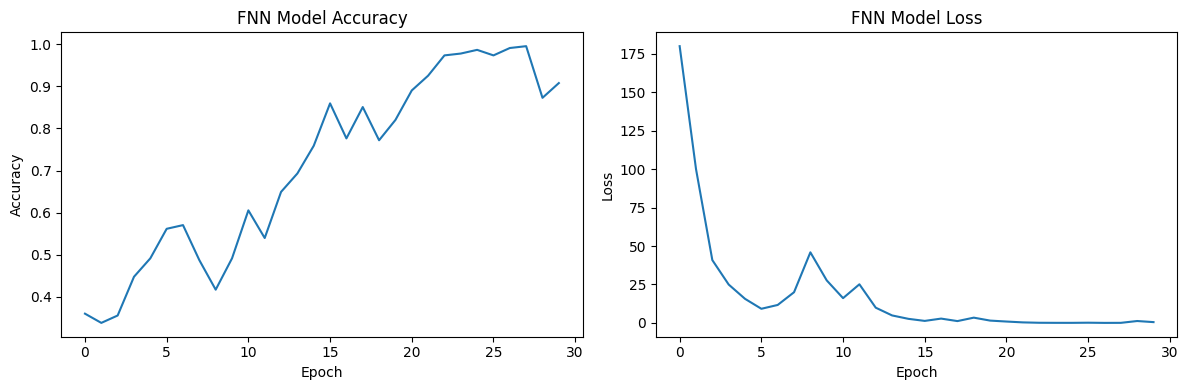

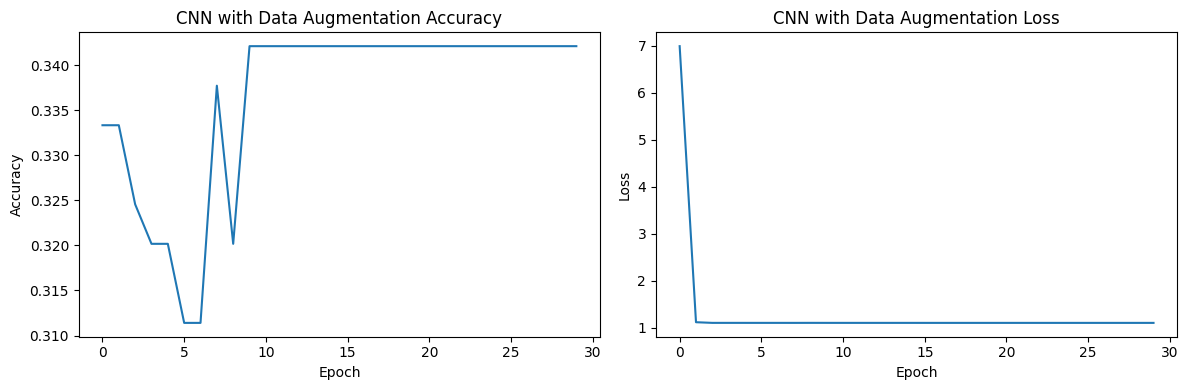

In [95]:
def plot_history(history, title):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.title(f'{title} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.title(f'{title} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.tight_layout()
    plt.show()


# Plot training history for each model
plot_history(histories["CNN"], 'CNN Model')
plot_history(histories["FNN"], 'FNN Model')
plot_history(histories["CNN_GEN"], 'CNN with Data Augmentation')


CNN Evaluation:
1/1 [==============================] - 0s 191ms/step

Classification Report:
                 precision    recall  f1-score   support

walking_running       0.20      0.15      0.17        20
        sitting       0.42      0.52      0.47        21
       standing       0.38      0.38      0.38        16

       accuracy                           0.35        57
      macro avg       0.33      0.35      0.34        57
   weighted avg       0.33      0.35      0.34        57



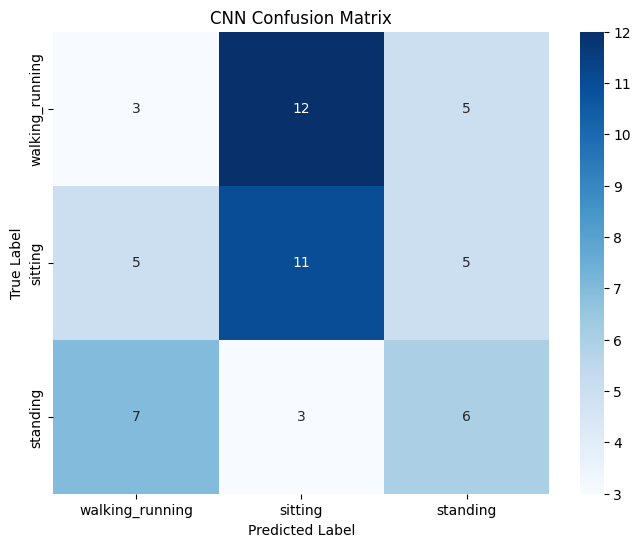

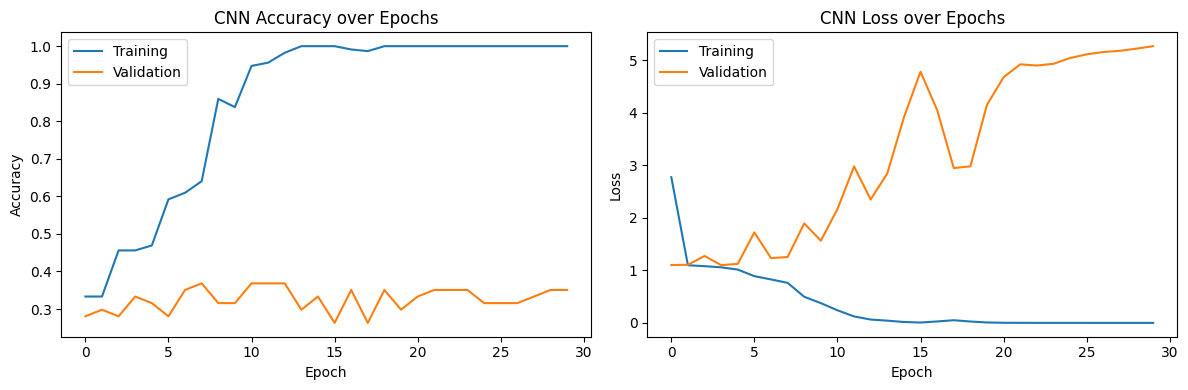


FNN Evaluation:
1/1 [==============================] - 0s 159ms/step

Classification Report:
                 precision    recall  f1-score   support

walking_running       0.00      0.00      0.00        20
        sitting       0.30      0.48      0.37        21
       standing       0.19      0.25      0.22        16

       accuracy                           0.25        57
      macro avg       0.16      0.24      0.20        57
   weighted avg       0.17      0.25      0.20        57



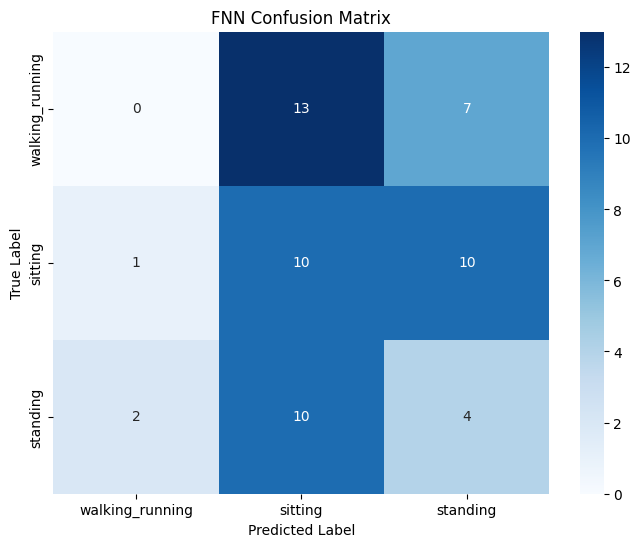

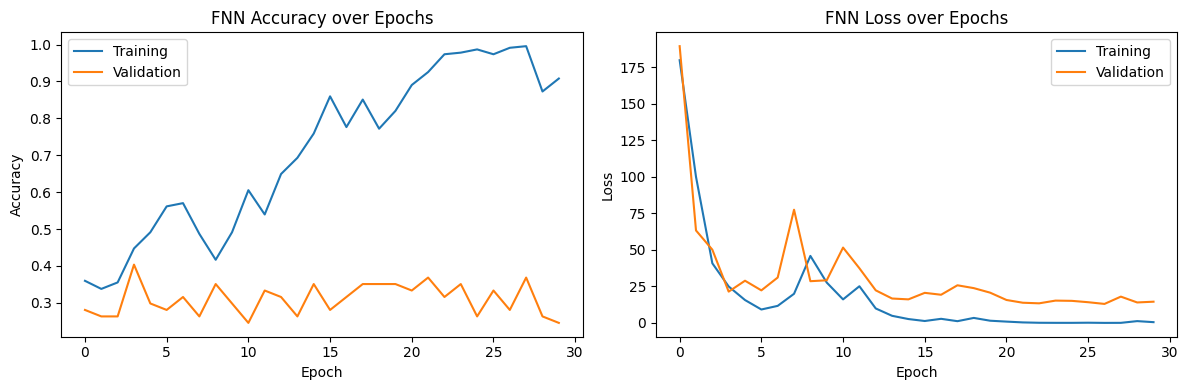


CNN_GEN Evaluation:
1/1 [==============================] - 1s 650ms/step

Classification Report:
                 precision    recall  f1-score   support

walking_running       0.35      1.00      0.52        20
        sitting       0.00      0.00      0.00        21
       standing       0.00      0.00      0.00        16

       accuracy                           0.35        57
      macro avg       0.12      0.33      0.17        57
   weighted avg       0.12      0.35      0.18        57



c:\Users\javie\Desktop\ABERDEEN\Data mining with deep learning\Project 1\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\javie\Desktop\ABERDEEN\Data mining with deep learning\Project 1\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\javie\Desktop\ABERDEEN\Data mining with deep learning\Project 1\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

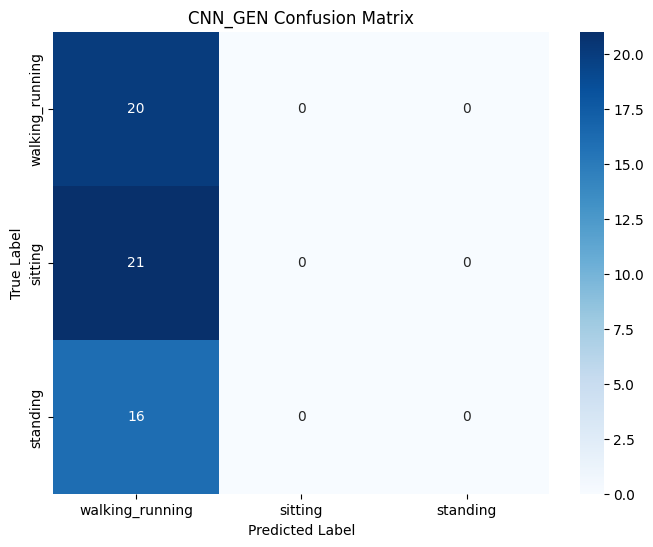

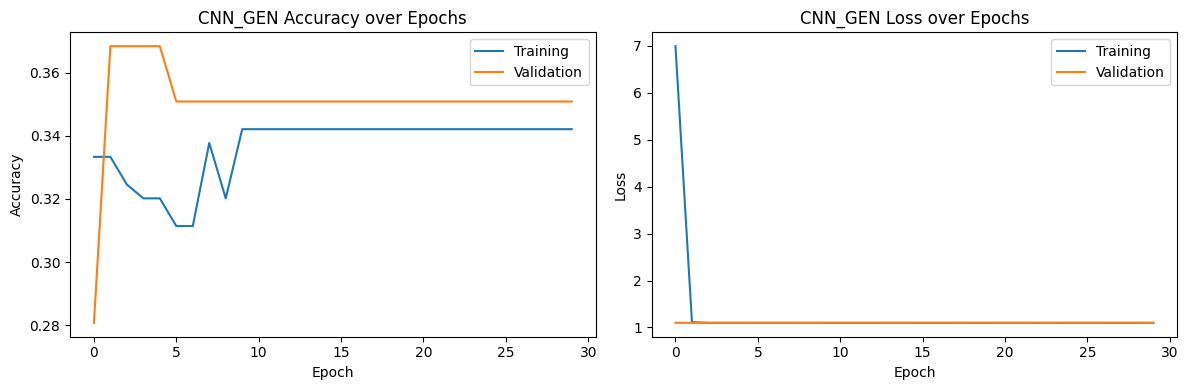

In [96]:
# Evaluate models and display metrics
def evaluate_model(model, model_name, test_ds):
    print(f"\n{model_name} Evaluation:")
    # Get predictions
    y_pred = []
    y_true = []
    for images, labels in test_ds:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(labels.numpy())
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, 
          target_names=['walking_running', 'sitting', 'standing']))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['walking_running', 'sitting', 'standing'],
                yticklabels=['walking_running', 'sitting', 'standing'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(histories[model_name].history['accuracy'], label='Training')
    plt.plot(histories[model_name].history['val_accuracy'], label='Validation')
    plt.title(f'{model_name} Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(histories[model_name].history['loss'], label='Training')
    plt.plot(histories[model_name].history['val_loss'], label='Validation')
    plt.title(f'{model_name} Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Evaluate each model
for model_name, model in models_dict.items():
    evaluate_model(model, model_name, test_ds)

### 6. Model Evaluation

In [97]:
print("\nModel Performance on Test Dataset:")
print("-" * 40)

try:
    # CNN evaluation
    cnn_loss, cnn_accuracy = models_dict["CNN"].evaluate(
        test_ds, 
        verbose=0
    )
    print(f'CNN Test Accuracy: {cnn_accuracy:.2%}')
    print(f'CNN Test Loss: {cnn_loss:.4f}')

    # FNN evaluation
    fnn_loss, fnn_accuracy = models_dict["FNN"].evaluate(
        test_ds, 
        verbose=0
    )
    print(f'FNN Test Accuracy: {fnn_accuracy:.2%}')
    print(f'FNN Test Loss: {fnn_loss:.4f}')

    # CNN with data augmentation evaluation
    cnn_gen_loss, cnn_gen_accuracy = models_dict["CNN_GEN"].evaluate(
        test_ds, 
        verbose=0
    )
    print(f'CNN with Data Augmentation Test Accuracy: {cnn_gen_accuracy:.2%}')
    print(f'CNN with Data Augmentation Test Loss: {cnn_gen_loss:.4f}')

except Exception as e:
    print(f"Error during model evaluation: {str(e)}")

print("-" * 40)


Model Performance on Test Dataset:
----------------------------------------
CNN Test Accuracy: 35.09%
CNN Test Loss: 5.2651
FNN Test Accuracy: 24.56%
FNN Test Loss: 14.5434
CNN with Data Augmentation Test Accuracy: 35.09%
CNN with Data Augmentation Test Loss: 1.0983
----------------------------------------
